# Import libs, initialize CUDA, mount Drive

In [ ]:
import sys
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, LongformerTokenizer, LongformerForSequenceClassification
from sentence_transformers import SentenceTransformer, InputExample, models, losses, CrossEncoder, util
from google.colab import drive


drive.mount("/content/drive", force_remount=True)
sys.path.insert(0, '*******')
from dataloader import Dataset # Additional data check
from extended_longformer import ExtendedLongformer # Added non-linear layer
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Device: {device}")

Mounted at /content/drive
Device: cuda:0


# Multi-Label, Multi-Class Classification

Fine tunnig LONGFORMER model on 60000 youtube videos' subtitles.

Dataset size: 57983
Train set size: 52184
Validation set size: 5799


Adjusting learning rate of group 0 to 5.0000e-05.


  0%|          | 0/1 [00:00<?, ?it/s]


Adjusting learning rate of group 0 to 4.7500e-05.


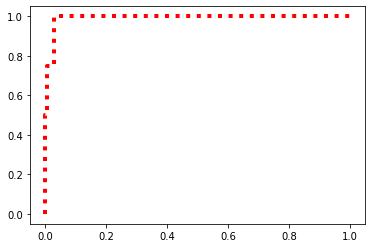

 100%|██████████| 1/1 [2:27:12<00:00, 8832.89s/it]


AUC: 0.9917582417582418


In [ ]:
torch.cuda.empty_cache()


def collate_fn(batch):
    '''
    Check for zero length inputs in batch
    '''
    batch = list(filter(lambda x: x is not None, batch))
    try:
      x = [item[0][0] for item in batch]
    except:
      for item in batch:
        print(item)
    y = [item[1] for item in batch]
    return x, y


def multiclass_auc_roc(target, y_pred):
    '''
    Compute AUC-ROC
    '''
    n_classes = target.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(torch.flatten(target),
                                              torch.flatten(y_pred))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="red",
        linestyle=":",
        linewidth=4,
    )
    plt.show()
    return roc_auc["micro"]


torch.cuda.empty_cache()
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
classes = ['Humour', 'Music_of_Asia', 'Rock_music', 'Tennis', 'Performing_arts',
           'Electronic_music', 'Video_game_culture', 'Independent_music',
           'Physical_attractiveness', 'Politics', 'Soul_music', 'Technology',
           'Music', 'Rhythm_and_blues', 'Ice_hockey', 'Cricket', 'Vehicle',
           'Tourism', 'Baseball', 'Lifestyle_(sociology)', 'Food', 'Motorsport',
           'Physical_fitness', 'Professional_wrestling', 'Action_game',
           'Fashion', 'Business', 'Health', 'Military', 'Simulation_video_game',
           'Association_football', 'Knowledge', 'Hip_hop_music',
           'Television_program', 'American_football', 'Reggae',
           'Mixed_martial_arts', 'Pet', 'Strategy_video_game', 'Film',
           'Casual_game', 'Entertainment', 'Music_video_game', 'Country_music',
           'Basketball', 'Hobby', 'Sport', 'Religion', 'Puzzle_video_game',
           'Jazz', 'Sports_game', 'Action-adventure_game', 'Christian_music',
           'Volleyball', 'Classical_music', 'Boxing', 'Music_of_Latin_America',
           'Pop_music', 'Golf', 'Racing_video_game', 'Society',
           'Role-playing_video_game']
data_path = **********
dataset_path = **********
dataset = json.load(open(dataset_path))
ids = list(dataset.keys())
train_prop = 0.9
test_prop = 1 - train_prop
train_size = int(len(ids)*train_prop)
val_size = len(ids)-train_size
train_ids, val_ids = torch.utils.data.random_split(ids, [train_size, val_size])
print(f'Dataset size: {len(ids)}')
print(f'Train set size: {len(train_ids)}')
print(f'Validation set size: {len(val_ids)}')
params = {'batch_size': 3,
          'shuffle': True,
          'num_workers': 8,
          'pin_memory': True}
training_set = Dataset(classes, train_ids, dataset, data_path)
training_generator = torch.utils.data.DataLoader(training_set,
                                                 collate_fn=collate_fn,
                                                 **params)
validation_set = Dataset(classes, val_ids, dataset, data_path)
validation_generator = torch.utils.data.DataLoader(validation_set,
                                                   collate_fn=collate_fn, 
                                                   **params)
model = LongformerForSequenceClassification.from_pretrained(
    "allenai/longformer-base-4096", num_labels=1000
    ).to(device).eval()
for name, param in model.named_parameters():
    if not name.startswith("classifier"):
         param.requires_grad = False
model = ExtendedLongformer(model, len(classes), 1000).to(device).eval()
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=0.00005,
                              betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            1,
                                            gamma=0.95,
                                            verbose=True)
loss_list = []
val_loss_list = []
epochs = 1
for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    for x, y in training_generator:
        # Zero gradients
        optimizer.zero_grad()
        try:
            batch_tok = tokenizer(x, return_tensors='pt', padding='max_length',
                          truncation=True, max_length=4096).to(device)
        except:
            pass
        else:
            y_batch = torch.tensor(y).to(device).float()
            y_pred = model(**batch_tok)
            loss = loss_fn(y_pred, y_batch)  
            loss.backward()
            optimizer.step()
    scheduler.step()
    loss_list.append(loss.item())
    with torch.no_grad():
        model.eval()
        for x, y in validation_generator:
            # Zero gradients
            try:
                batch_tok = tokenizer(x,
                                      return_tensors='pt',
                                      padding='max_length',
                                      truncation=True,
                                      max_length=4096).to(device)
            except:
                pass
            else:
                y_batch = torch.tensor(y).to(device).float()
                y_pred = model(batch_tok['input_ids'])
                loss = loss_fn(y_pred, y_batch)  
                break
        val_loss_list.append(loss.item)
    torch.save(model.state_dict(), 'longformer-4096-' + str(epoch))
    cls = torch.nn.Sigmoid()
    out = cls(y_pred)
    ar = multiclass_auc_roc(y_batch.cpu(), out.cpu())
    print("\n", ar)